## References
- For feature extraction I used  `https://github.com/SuperCowPowers/data_hacking/blob/master/pefile_classification/pe_features.py`
- For modelling reference using tree models with Tensorflow I used `https://www.tensorflow.org/decision_forests/tutorials/beginner_colab`
- attached: 
    - `pefile_attributes.py` that works wiht python 3.10
    - images that are in the 

# Baseline Model performance

From Exploratory Data Analysis we observed that the malware files tends towards to exe files. 
- Clean files `{'dll': 7669, 'exe': 2800}`
- Infexted files `{'exe': 13889, 'dll': 654}`

Moreover we noticed that file size distribution is different for clean and infected files. 
![file_ze](file_size_distribution.png)

For the baseline model we decided to use out of the box random forest model and the two features described above. 
`is_exe` and `file_size`.

Next we split the data into train test (0.7, 0.3) sets and train the model. 

For the model training we used accuracy metric. 

For the prediction cut off we used 0.5. 

#### The model metrics are: 
```
FPR = fp / (tn + fp) = 0.147
accuracy = 0.89
F1_score = 0.91
```

Confusion matrix 
![confusion_matrix](confusion_matrix_base_model.png)

From the confussion matrix we see that the model quite well predicts True positive - lower bottom corner.  On the other hand the model missclasifies the clean files. Our false positive rate is equal to `FPR = 0.147`. 

#### How to reduce FPR

First we must be avare that we are optimizing several metrics at once - accuracy and FPR. 
To reduce FPR we can try sevaral approaches. 

Fast fixes
1. choose more appropriate cut off point. For example 
    - `cut off point 0.7` returns `FPR = 0.118` with `accuracy = 0.9` and `F1_score = 0.89`.
    - `cut off point 0.95` returns `FPR = 0.053` with `accuracy = 0.81` and `F1_score = 0.81`.
    
2. Improve the model by: 
    1. tuning hyperparameters
    2. training model on another algorithms
    
Time consuming fixes

- Extracting more features. 
- Error analysis. Investigate what files  the model clasifies incorectly and check is it possible to improve the data. 


## GBoosting model performance using non-null features (the column must have at least 90% on non null values)
![](xgboost_cm.png)
- `FPR = 0.008`
- `F1_score = 0.976`
- `accuracy = 0.972`


In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [52]:
import numpy as np
import pandas as pd
import tensorflow_decision_forests as tfdf

<IPython.core.display.Javascript object>

In [6]:
import joblib

<IPython.core.display.Javascript object>

In [7]:
clean_dll = joblib.load("data/clean_dll_files_features.gz")
clean_exe = joblib.load("data/clean_exe_files_features.gz")
infected_dll = joblib.load("data/infected_dll_files_features.gz")
infected_exe = joblib.load("data/infected_exe_files_features.gz")

<IPython.core.display.Javascript object>

In [42]:
col_names = ["file_name", "file_size"]
clean_df_dll = pd.DataFrame(
    [[i["file_name"], i["file_size"]] for i in clean_dll], columns=col_names
)
clean_df_dll["is_exe"] = 0
clean_df_dll["target"] = 0

infected_df_dll = pd.DataFrame(
    [[i["file_name"], i["file_size"]] for i in infected_dll], columns=col_names
)
infected_df_dll["is_exe"] = 0
infected_df_dll["target"] = 1

clean_df_exe = pd.DataFrame(
    [[i["file_name"], i["file_size"]] for i in clean_exe], columns=col_names
)
clean_df_exe["is_exe"] = 1
clean_df_exe["target"] = 0

infected_df_exe = pd.DataFrame(
    [[i["file_name"], i["file_size"]] for i in infected_exe], columns=col_names
)
infected_df_exe["is_exe"] = 1
infected_df_exe["target"] = 1


df = pd.concat([clean_df_dll, infected_df_dll, clean_df_exe, infected_df_exe])

<IPython.core.display.Javascript object>

In [46]:
df = df.drop("file_name", axis=1)

<IPython.core.display.Javascript object>

In [47]:
df = df.sample(frac=1).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [48]:
label = "target"

<IPython.core.display.Javascript object>

In [49]:
def split_dataset(dataset, test_ratio=0.30):
    """Splits a panda dataframe in two."""
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(df)
print(
    "{} examples in training, {} examples for testing.".format(
        len(train_ds_pd), len(test_ds_pd)
    )
)

17518 examples in training, 7436 examples for testing.


<IPython.core.display.Javascript object>

In [50]:
feature_columns = []
for feature_name in ["file_size", "is_exe"]:
    feature_columns.append(
        tf.feature_column.numeric_column(feature_name, dtype=tf.float32)
    )

<IPython.core.display.Javascript object>

In [105]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

<IPython.core.display.Javascript object>

In [104]:
# model_1 = tfdf.keras.GradientBoostedTreesModel(verbose=2)
model_1 = tfdf.keras.RandomForestModel(verbose=2)
# Train the model.
model_1.fit(train_ds)

Use 8 thread(s) for training
Use /var/folders/kc/xzqn6jtj2n36swv3ywh1znb80000gn/T/tmpx5x6tel_ as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'file_size': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'is_exe': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>}
Label: Tensor("data_2:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'file_size': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'is_exe': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>)}
Training dataset read in 0:00:00.244018. Found 17518 examples.
Training model...


[INFO 2023-03-01T13:16:09.051938+02:00 kernel.cc:756] Start Yggdrasil model training
[INFO 2023-03-01T13:16:09.052073+02:00 kernel.cc:757] Collect training examples
[INFO 2023-03-01T13:16:09.052121+02:00 kernel.cc:388] Number of batches: 18
[INFO 2023-03-01T13:16:09.052136+02:00 kernel.cc:389] Number of examples: 17518
[INFO 2023-03-01T13:16:09.052758+02:00 kernel.cc:774] Training dataset:
Number of records: 17518
Number of columns: 3

Number of columns by type:
	NUMERICAL: 2 (66.6667%)
	CATEGORICAL: 1 (33.3333%)

Columns:

NUMERICAL: 2 (66.6667%)
	1: "file_size" NUMERICAL mean:464065 min:0 max:4.23909e+06 sd:593235
	2: "is_exe" NUMERICAL mean:0.663946 min:0 max:1 sd:0.472358

CATEGORICAL: 1 (33.3333%)
	0: "__LABEL" CATEGORICAL integerized vocab-size:3 no-ood-item

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The

[INFO 2023-03-01T13:16:10.745104+02:00 kernel.cc:1214] Loading model from path /var/folders/kc/xzqn6jtj2n36swv3ywh1znb80000gn/T/tmpx5x6tel_/model/ with prefix 6f18e2bcdcb549b7
[INFO 2023-03-01T13:16:11.68678+02:00 decision_forest.cc:661] Model loaded with 300 root(s), 359314 node(s), and 2 input feature(s).
[INFO 2023-03-01T13:16:11.686834+02:00 abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 2023-03-01T13:16:11.686862+02:00 kernel.cc:1046] Use fast generic engine


Model trained in 0:00:02.738554
Compiling model...
Model compiled.


<IPython.core.display.Javascript object>

In [70]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

8/8 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 0.8930

loss: 0.0000
accuracy: 0.8930


<IPython.core.display.Javascript object>

In [72]:
model_1.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (2):
	file_size
	is_exe

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.    "is_exe"  1.000000 ################
    2. "file_size"  0.500000 

Variable Importance: NUM_AS_ROOT:
    1. "is_exe" 300.000000 

Variable Importance: NUM_NODES:
    1. "file_size" 179207.000000 ################
    2.    "is_exe" 300.000000 

Variable Importance: SUM_SCORE:
    1.    "is_exe" 1525062.142914 ################
    2. "file_size" 1025461.102064 



Winner takes all: true
Out-of-bag evaluation: accuracy:0.896849 logloss:1.4794
Number of trees: 300
Total number of nodes: 359314

Number of nodes by tree:
Count: 300 Average: 1197.7

<IPython.core.display.Javascript object>

In [73]:
model_1.make_inspector().variable_importances()

{'SUM_SCORE': [("is_exe" (1; #2), 1525062.1429144144),
  ("file_size" (1; #1), 1025461.1020636384)],
 'NUM_AS_ROOT': [("is_exe" (1; #2), 300.0)],
 'INV_MEAN_MIN_DEPTH': [("is_exe" (1; #2), 1.0),
  ("file_size" (1; #1), 0.500000000000001)],
 'NUM_NODES': [("file_size" (1; #1), 179207.0), ("is_exe" (1; #2), 300.0)]}

<IPython.core.display.Javascript object>

In [74]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=17518, accuracy=0.8968489553602009, loss=1.4794008014794897, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

<IPython.core.display.Javascript object>

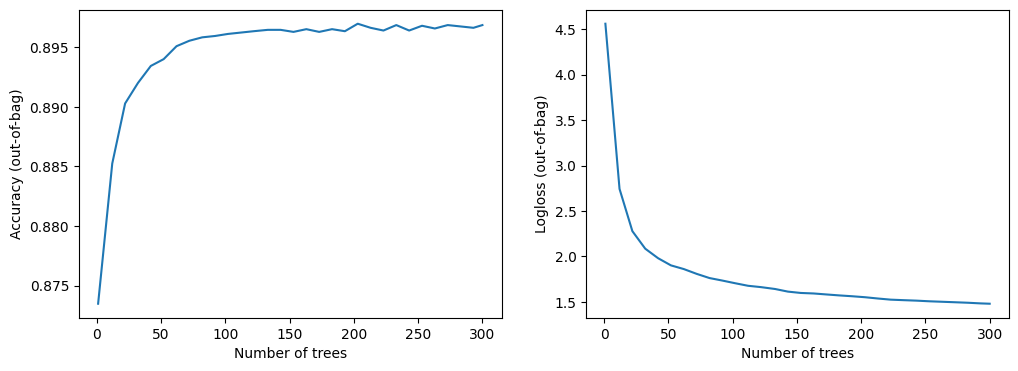

<IPython.core.display.Javascript object>

In [75]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [77]:
preds = model_1.predict(test_ds)

8/8 [==============================] - 0s 29ms/step


<IPython.core.display.Javascript object>

In [159]:
y_pred = [1 if i[0] > 0.7 else 0 for i in list(preds)]

<IPython.core.display.Javascript object>

In [160]:
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)

<IPython.core.display.Javascript object>

In [161]:
y_test = test_ds_pd.target.values.tolist()

<IPython.core.display.Javascript object>

In [162]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
pd.DataFrame(
    cm,
    columns=["0_predict", "1_predict"],
    index=["0_true", "1_true"],
)

,0_predict,1_predict
0_true,2708,364
1_true,475,3889


<IPython.core.display.Javascript object>

In [163]:
FPR = fp / (tn + fp)
FPR

0.11848958333333333

<IPython.core.display.Javascript object>

In [164]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred), precision_score(
    y_test, y_pred
), recall_score(y_test, y_pred)

(0.9026343274921667,
 0.8871705217859064,
 0.9144133552786269,
 0.8911549037580202)

<IPython.core.display.Javascript object>

## Gradient Boosted tree model

In [ ]:
clean_dll = joblib.load("data/clean_dll_files_features.gz")
clean_exe = joblib.load("data/clean_exe_files_features.gz")
infected_dll = joblib.load("data/infected_dll_files_features.gz")
infected_exe = joblib.load("data/infected_exe_files_features.gz")

In [168]:
dll_0 = pd.DataFrame(clean_dll)
dll_0['is_exe'] = 0
dll_0['target'] = 0

dll_1 = pd.DataFrame(infected_dll)
dll_1['is_exe'] = 0
dll_1['target'] = 1

exe_0 = pd.DataFrame(clean_exe)
exe_0['is_exe'] = 1
exe_0['target'] = 0

exe_1 = pd.DataFrame(infected_exe)
exe_1['is_exe'] = 1
exe_1['target'] = 1


<IPython.core.display.Javascript object>

In [169]:
df = pd.concat([dll_0, dll_1, exe_0, exe_1])

<IPython.core.display.Javascript object>

In [172]:
df.drop("file_name", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [174]:
columns = df.loc[:, df.notnull().mean() > 0.90].columns

<IPython.core.display.Javascript object>

In [175]:
df = df[columns].copy()

<IPython.core.display.Javascript object>

In [179]:
df = df.sample(frac=1).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [180]:
label = "target"

<IPython.core.display.Javascript object>

In [181]:
train_ds_pd, test_ds_pd = split_dataset(df)
print(
    "{} examples in training, {} examples for testing.".format(
        len(train_ds_pd), len(test_ds_pd)
    )
)

17548 examples in training, 7406 examples for testing.


<IPython.core.display.Javascript object>

In [185]:
feature_columns = []
for feature_name in columns.tolist()[:-1]:
    feature_columns.append(
        tf.feature_column.numeric_column(feature_name, dtype=tf.float32)
    )

<IPython.core.display.Javascript object>

In [187]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

<IPython.core.display.Javascript object>

In [188]:
# A more complex, but possibly, more accurate model.
model_7 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500,
    growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=8,
    split_axis="SPARSE_OBLIQUE",
    categorical_algorithm="RANDOM",
)
model_7.fit(train_ds)

Use /var/folders/kc/xzqn6jtj2n36swv3ywh1znb80000gn/T/tmp9x08knus as temporary training directory
Reading training dataset...


Training dataset read in 0:00:01.428850. Found 17548 examples.
Training model...


2023-03-01 13:45:07.955401: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-03-01 13:45:07.955472: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-03-01 13:45:07.955482: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-03-01 13:45:07.957114: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:452] Default loss set to BINOMIAL_LOG_LIKELIHOOD
2023-03-01 13:45:07.957161: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 17548 example(s) and 55 feature(s).
2023-03-01 13:45:07

Model trained in 0:09:14.372462
Compiling model...


2023-03-01 13:54:22.217972: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1568] Create final snapshot of the model at iteration 160
2023-03-01 13:54:22.228671: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:247] Truncates the model to 131 tree(s) i.e. 131  iteration(s).
2023-03-01 13:54:22.229233: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:309] Final model num-trees:131 valid-loss:0.121232 valid-accuracy:0.980881
[INFO 2023-03-01T13:54:22.259749+02:00 kernel.cc:1214] Loading model from path /var/folders/kc/xzqn6jtj2n36swv3ywh1znb80000gn/T/tmp9x08knus/model/ with prefix a92bb7b7403441cc
[INFO 2023-03-01T13:54:22.307325+02:00 decision_forest.cc:661] Model loaded with 131 root(s), 7891 node(s), and 55 input feature(s).
[INFO 2023-03-01T13:54:22.307375+02:00 abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 2

Model compiled.


<IPython.core.display.Javascript object>

In [189]:
preds = model_7.predict(test_ds)

8/8 [==============================] - 0s 35ms/step


<IPython.core.display.Javascript object>

In [192]:
y_test = test_ds_pd.target.values.tolist()

<IPython.core.display.Javascript object>

In [211]:
y_pred = [1 if i[0] > 0.95 else 0 for i in list(preds)]

<IPython.core.display.Javascript object>

In [212]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
pd.DataFrame(
    cm,
    columns=["0_predict", "1_predict"],
    index=["0_true", "1_true"],
)

,0_predict,1_predict
0_true,3031,25
1_true,175,4175


<IPython.core.display.Javascript object>

In [213]:
FPR = fp / (tn + fp)
FPR

0.008180628272251309

<IPython.core.display.Javascript object>

In [214]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred), precision_score(
    y_test, y_pred
), recall_score(y_test, y_pred)

(0.976608187134503, 0.9729948690251148, 0.9940476190476191, 0.9597701149425287)

<IPython.core.display.Javascript object>